In [1]:
import pandas as pd
import numpy as np 
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image


Image Validation and Organization Script

In [5]:
import os
from PIL import Image, UnidentifiedImageError

import shutil

# Function to check if an image is valid
def is_valid_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verifies the image integrity
        return True
    except (IOError, UnidentifiedImageError):
        return False

# Path to the folder containing images
image_folder_path = "C:/Users/jagji/OneDrive/Desktop/all"  # Path to the folder containing all images
output_folder_path = 'photos\\valid_images'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Collect valid image paths, limiting to the first 2000 images
valid_image_paths = []

for f in os.listdir(image_folder_path):
    image_path = os.path.join(image_folder_path, f)
    if f.endswith(('.jpg', '.png')) and is_valid_image(image_path):
        valid_image_paths.append(image_path)
    if len(valid_image_paths) >= 2000:  # Stop when 2000 valid images are collected
        break

# Display how many valid images were collected
print(f"Collected {len(valid_image_paths)} valid images.")

# Copy the valid images to the new folder
for image_path in valid_image_paths:
    # Extract the filename from the path
    filename = os.path.basename(image_path)
    # Define the output path
    output_path = os.path.join(output_folder_path, filename)
    # Copy the image to the output folder
    shutil.copy(image_path, output_path)

print(f"Saved {len(valid_image_paths)} valid images to {output_folder_path}.")


Collected 2000 valid images.
Saved 2000 valid images to photos\valid_images.


Define Preprocessing and Data Loading

In [6]:
# Step 1: Define Preprocessing and Data Loading
transform = transforms.Compose([
    transforms.Resize((32,32)),  # Resize images to 32x32
    transforms.RandomRotation(15),  # Randomly rotate images
    transforms.RandomHorizontalFlip(),  # Flip images horizontally
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [7]:
 # Step2: Path to dataset folder
dataset = datasets.ImageFolder(root='photos', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

Generator Model for Image Generation

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# Step 1: Define the Generator Model
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 256),  # From z_dim (100) to 256
            nn.ReLU(True),
            nn.Linear(256, 512),  # From 256 to 512
            nn.ReLU(True),
            nn.Linear(512, 1024),  # From 512 to 1024
            nn.ReLU(True),
            nn.Linear(1024, 3 * 32 * 32),  # Output layer: 3 * 128 * 128 = 49152
            nn.Tanh()  # Normalize the output to the range [-1, 1]
        )

    def forward(self, z):
        # Flatten the input tensor to shape (batch_size, z_dim)
        z = z.view(z.size(0), -1)  # Flatten: (batch_size, z_dim)
        
        out = self.fc(z)  # Pass through fully connected layers
        return out.view(-1, 3, 32, 32)  


Define the Discriminator Model

In [9]:
# Step 2: Define the Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3*32*32, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability for real/fake classification
        )

    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))



Initialize Models and Optimizers

In [10]:

# Step 3: Initialize Models and Optimizers
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

z_dim = 100  # Latent space dimension
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

optimizer_gen = optim.Adam(gen.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(disc.parameters(), lr=0.002, betas=(0.5, 0.999))

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss


Training Loop for GAN

In [29]:
# Step 4: Training Loop
num_epochs = 2  # Set the number of epochs
for epoch in range(num_epochs):
    for real_images, _ in dataloader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Generate fake images
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_images = gen(noise)

        # Train Discriminator
        optimizer_disc.zero_grad()
        real_output = disc(real_images)  # Real images through the discriminator
        fake_output = disc(fake_images.detach())  # Fake images through the discriminator

        # Labels for real and fake images (real=1, fake=0)
        real_labels = torch.ones(batch_size, 1).to(device)  # Shape: (batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1).to(device)  # Shape: (batch_size, 1)

        # Compute Discriminator losses
        real_loss = criterion(real_output, real_labels)
        fake_loss = criterion(fake_output, fake_labels)
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        optimizer_disc.step()

        # Train Generator
        optimizer_gen.zero_grad()

        # Generator loss: want to fool the discriminator into thinking fake images are real
        gen_loss = criterion(disc(fake_images), real_labels)  # Use real_labels to fool the discriminator
        gen_loss.backward()
        optimizer_gen.step()

    # Print losses and save generated images every epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Disc Loss: {disc_loss.item():.4f}, Gen Loss: {gen_loss.item():.4f}')

    # Save generated images every few epochs
    if (epoch + 1) % 1 == 0:  # Save image samples every epoch
        save_image(fake_images.data[:5], f'generated_images_epoch_{epoch + 1}.png', nrow=5, normalize=True)




Epoch [1/2], Disc Loss: 1.3327, Gen Loss: 0.7168
Epoch [2/2], Disc Loss: 1.2460, Gen Loss: 0.7897


OBSERVATIONS

1.Discriminator Loss (~1.33-1.24): Moderate loss indicates the discriminator is somewhat effective but still learning.  
2.Generator Loss(~0.71-0.71): Higher loss shows the generator is struggling to consistently fool the discriminator.  
3.Early Training: Only 2 epochs suggest the model is in the initial learning phase; more epochs are needed for improvement.

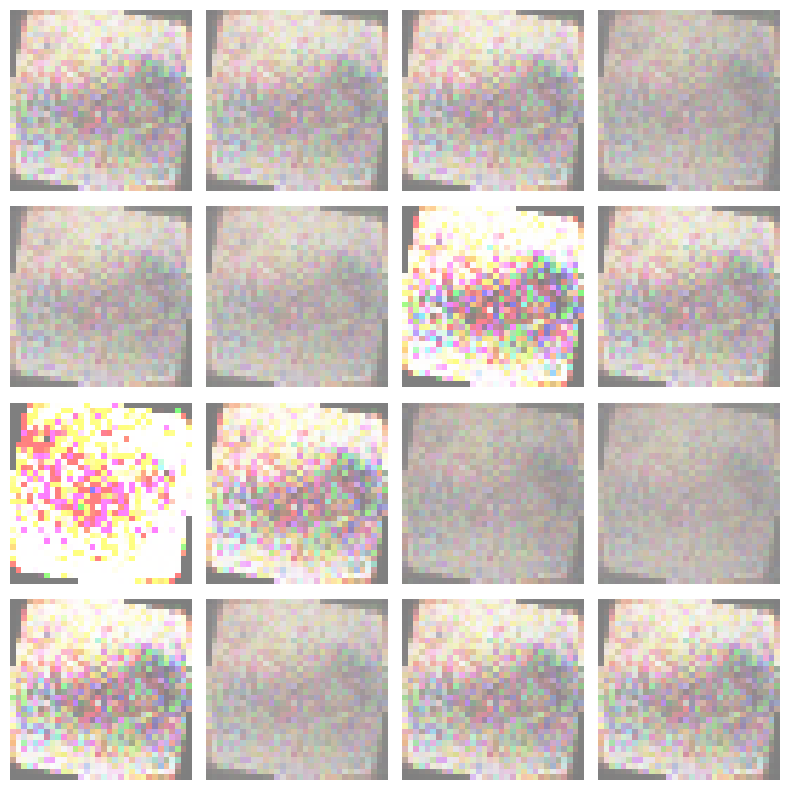

In [28]:
# Assume generated_images has shape [Batch, 3072] and needs reshaping
batch_size, flat_size = generated_images.shape
channels = 3  # Likely RGB
height = width = int((flat_size // channels) ** 0.5)  # Calculate height and width

# Reshape generated images to [Batch, Channels, Height, Width]
reshaped_images = generated_images.view(batch_size, channels, height, width)

# Normalize back to [0, 1] for display
reshaped_images = (reshaped_images + 1) / 2

# Plot the images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(reshaped_images[i].permute(1, 2, 0).cpu().detach().numpy())
    ax.axis('off')
plt.tight_layout()
plt.show()


OBSERVATIONS

1.Discriminator Loss (~1.18-0.85): Moderate loss indicates the discriminator is somewhat effective but still learning.  
2.Generator Loss(~0.85-1.05): Higher loss shows the generator is struggling to consistently fool the discriminator.  
3.Early Training: Only 2 epochs suggest the model is in the initial learning phase; more epochs are needed for improvement.

The Generator maps a latent vector `z` to a structured RGB image using fully connected layers with `ReLU` activations and a `Tanh` output for normalization.  


In [30]:

# Step 1: Define the Generator Model
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(z_dim, 256),  # From z_dim (100) to 256
            nn.ReLU(True),
            nn.Linear(256, 512),  # From 256 to 512
            nn.ReLU(True),
            nn.Linear(512, 1024),  # From 512 to 1024
            nn.ReLU(True),
            nn.Linear(1024, 3 * 32 * 32), 
            nn.Tanh()  # Normalize the output to the range [-1, 1]
        )
    def forward(self, z):
        # Flatten the input tensor to shape (batch_size, z_dim)
        z = z.view(z.size(0), -1)  # Flatten: (batch_size, z_dim)
        out = self.fc(z)  # Matrix multiplication happens here
        return out  

The Discriminator classifies images as real or fake by flattening inputs and passing them through fully connected layers with LeakyReLU activations and a Sigmoid output.  


In [31]:


# Step 2: Define the Discriminator Model
import torch.nn as nn
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),  # Input layer to 1024 units
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),  # 1024 units to 512 units
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),  # Directly output 1 unit for real/fake classification
            nn.Sigmoid()  # Sigmoid to output a probability (real/fake)
        )
    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))


In [32]:

# Step 3: Initialize Models and Optimizers
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

z_dim = 100  # Latent space dimension
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)
optimizer_gen = optim.Adam(gen.parameters(), lr=0.002, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(disc.parameters(), lr=0.0004, betas=(0.5, 0.999))
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
# Step 4: Training Loop
num_epochs = 2

for epoch in range(num_epochs):
    for real_images, _ in dataloader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        # Generate fake images
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_images = gen(noise)
        # Train Discriminator
        optimizer_disc.zero_grad()
        real_output = disc(real_images)  # Real images through the discriminator
        fake_output = disc(fake_images.detach())  # Fake images through the discriminator
        # Labels for real and fake images (real=1, fake=0)
        # Correct label shapes
        real_labels = torch.ones(batch_size, 1).to(device)  # Shape: (batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1).to(device)  # Shape: (batch_size, 1)
# Compute losses
        real_loss = criterion(real_output, real_labels)
        fake_loss = criterion(fake_output, fake_labels)
        disc_loss = real_loss + fake_loss
        # Compute losses
        disc_loss.backward()
        optimizer_disc.step()

        # Train Generator
        optimizer_gen.zero_grad()

        # Generator loss: want to fool the discriminator into thinking fake images are real
        gen_loss = criterion(disc(fake_images), real_labels)  # Use real_labels to fool the discriminator
        gen_loss.backward()
        optimizer_gen.step()

    # Print losses and save generated images every few epochs
    print(f'Epoch [{epoch+1}/{num_epochs}], Disc Loss: {disc_loss.item()}, Gen Loss: {gen_loss.item()}')

    if (epoch + 1) % 2 == 0:  # Save image samples every 10 epochs
        save_image(fake_images.data[:5], f'generated_images_epoch_{epoch+1}.png', nrow=5, normalize=True)



Epoch [1/2], Disc Loss: 1.6064106225967407, Gen Loss: 0.8885555267333984
Epoch [2/2], Disc Loss: 1.6492431163787842, Gen Loss: 0.8564804196357727


Observations:
Discriminator Loss: The discriminator loss slightly increased (~1.61 → ~1.65), indicating it is becoming more confident in distinguishing real and fake images.
Generator Loss: The generator loss decreased slightly (~0.89 → ~0.86), suggesting the generator is improving but still struggling to fool the discriminator effectively.

The `inception_score` function evaluates generated images by resizing them, passing them through a pretrained Inception v3 model, and calculating the exponential mean of entropy-based diversity and quality scores.  


In [33]:
from torchvision.models import inception_v3
from scipy.stats import entropy
# Evaluation Metrics
def inception_score(images, splits=10):
    model = inception_v3(pretrained=True, transform_input=False).eval()
    transform = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    images = torch.stack([transform(img) for img in images])
    with torch.no_grad():
        preds = torch.softmax(model(images), dim=1).cpu().numpy()
    scores = []
    for i in range(splits):
        part = preds[i * (len(preds) // splits): (i + 1) * (len(preds) // splits)]
        py = np.mean(part, axis=0)
        scores.append(np.mean([entropy(pyx, py) for pyx in part]))
    return np.exp(np.mean(scores))


The `calculate_fid` function computes the Fréchet Inception Distance (FID) between real and fake images by extracting features using a pretrained Inception v3 model, comparing the means and covariances of their feature distributions, and measuring the distance.  


In [34]:

import numpy as np

from scipy.linalg import sqrtm
def calculate_fid(real_images, fake_images):
    model = inception_v3(pretrained=True, transform_input=False).eval()
    def get_features(images):
        with torch.no_grad():
            return model(images).cpu().numpy()
    real_features = get_features(real_images)
    fake_features = get_features(fake_images)
    mu_r, sigma_r = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_g, sigma_g = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)
    diff = mu_r - mu_g
    covmean = sqrtm(sigma_r.dot(sigma_g))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return np.sum(diff**2) + np.trace(sigma_r + sigma_g - 2 * covmean)


The `transform` adds 37-pixel padding and converts images to PyTorch tensors.  


In [40]:
transform = transforms.Compose([
    transforms.Pad(padding=37), # Add padding to make smaller dimensions >= 75
    transforms.Resize((75, 75)), # Resize all images to 75x75 after padding
    transforms.ToTensor()
])

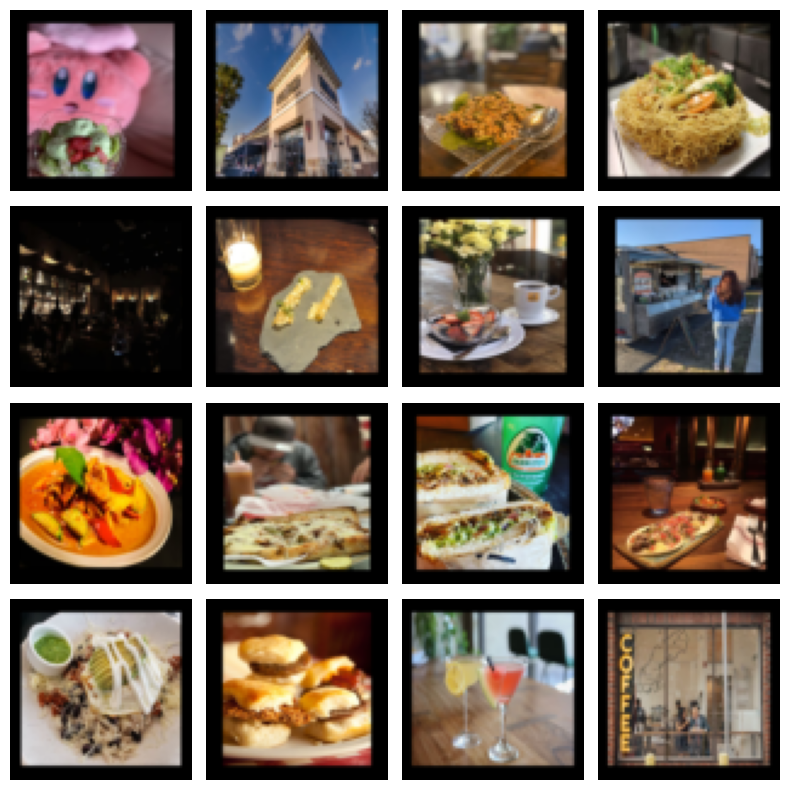

In [ ]:
#  Load dataset and apply the transformation
dataset = datasets.ImageFolder(root='photos', transform=transform)

# Visualize a few transformed images
def visualize_transformed_images(dataset, num_images=16):
    loader = torch.utils.data.DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(loader))  # Get one batch of images and labels

    # Plot the images
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            image = images[i].permute(1, 2, 0).cpu().detach().numpy()  # Convert [C, H, W] to [H, W, C]
            ax.imshow(image)
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the padded and resized images
visualize_transformed_images(dataset)

Reshaping and Resizing Flattened Tensors for Further Use

In [75]:
import torch
import torch.nn.functional as F

# Example: eval_fake_images starts as [1000, 3072]
eval_fake_images = torch.randn(1000, 3072)  # Replace this with your actual tensor

# Debug: Print initial shape
print(f"Initial shape of eval_fake_images: {eval_fake_images.shape}")

# Step 1: Reshape the tensor if flattened
if eval_fake_images.dim() == 2:  # If [Batch, Flattened]
    batch_size = eval_fake_images.size(0)
    channels = 3  # RGB
    height, width = 32, 32  # Original image dimensions
    eval_fake_images = eval_fake_images.view(batch_size, channels, height, width)
    print(f"Reshaped eval_fake_images: {eval_fake_images.shape}")  # [1000, 3, 32, 32]

# Step 2: Resize the tensor
fake_images_resized = F.interpolate(eval_fake_images, size=(75, 75), mode='bilinear')
print(f"Resized fake_images: {fake_images_resized.shape}")  # [1000, 3, 75, 75]


Initial shape of eval_fake_images: torch.Size([1000, 3072])
Reshaped eval_fake_images: torch.Size([1000, 3, 32, 32])
Resized fake_images: torch.Size([1000, 3, 75, 75])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0215318..3.697809].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1730797..2.6458755].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.880475..3.1306806].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.7540047..2.942659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.71131..3.0847642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.348544..3.1050262].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1863165..3.5

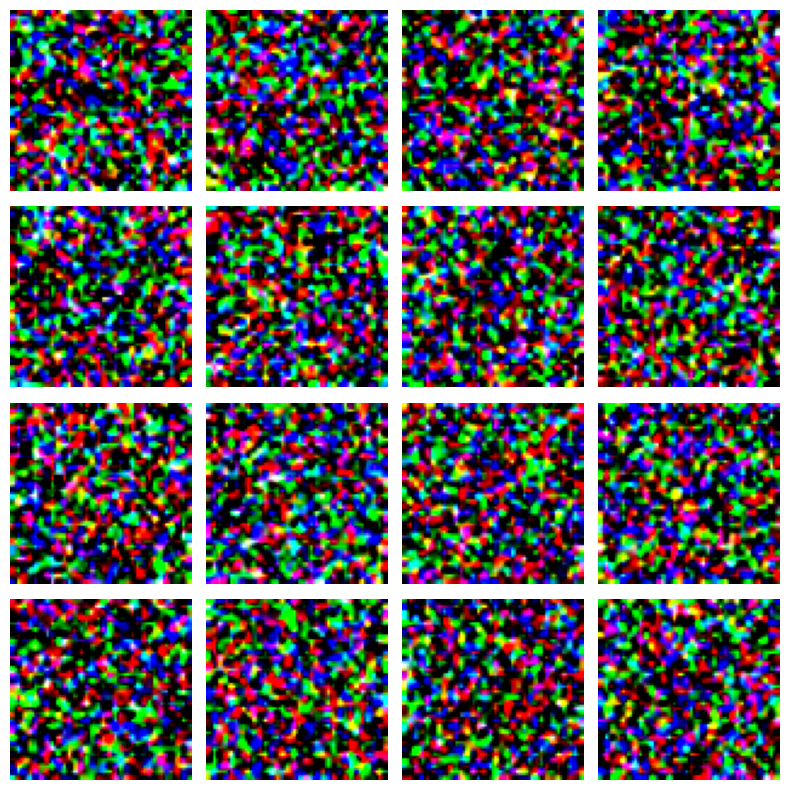

In [76]:
# visualization of resized images

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    if i < len(fake_images_resized):
        image = fake_images_resized[i].permute(1, 2, 0).cpu().detach().numpy()
        ax.imshow(image)
        ax.axis('off')
plt.tight_layout()
plt.show()



In [77]:


import torch.nn.functional as F

# Resize real_images
real_images_resized = F.interpolate(real_images, size=(75, 75), mode='bilinear')
print(f"Resized real_images shape: {real_images_resized.shape}")  # Should be [16, 3, 75, 75]

# Resize eval_fake_images
fake_images_resized = F.interpolate(eval_fake_images, size=(75, 75), mode='bilinear')
print(f"Resized eval_fake_images shape: {fake_images_resized.shape}")  # Should be [1000, 3, 75, 75]



Resized real_images shape: torch.Size([16, 3, 75, 75])
Resized eval_fake_images shape: torch.Size([1000, 3, 75, 75])


 GAN Training Loop with Evaluation Metrics

In [79]:
num_epochs = 1
z_dim = 100  # Latent space dimension

for epoch in range(num_epochs):
    total_disc_loss = 0
    total_gen_loss = 0

    for real_images, _ in dataloader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_disc.zero_grad()

        # Generate fake images
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_images = gen(noise).detach()

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Discriminator loss
        real_loss = criterion(disc(real_images), real_labels)
        fake_loss = criterion(disc(fake_images), fake_labels)
        disc_loss = real_loss + fake_loss

        # Backward pass for discriminator
        disc_loss.backward()
        optimizer_disc.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_gen.zero_grad()

        # Generate new fake images
        noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_images = gen(noise)

        # Generator loss (fool discriminator)
        gen_loss = criterion(disc(fake_images), real_labels)

        # Backward pass for generator
        gen_loss.backward()
        optimizer_gen.step()

        # Accumulate losses
        total_disc_loss += disc_loss.item()
        total_gen_loss += gen_loss.item()

    # Print average losses for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] | Disc Loss: {total_disc_loss / len(dataloader):.4f} | "
          f"Gen Loss: {total_gen_loss / len(dataloader):.4f}")

    # ---------------------
    # FID and Inception Score Calculation
    # ---------------------
    if (epoch + 1) % 1 == 0:  # Evaluate every epoch
        with torch.no_grad():
            # Generate a large batch of fake images
            num_eval_images = 1000
            eval_noise = torch.randn(num_eval_images, z_dim, 1, 1).to(device)
            eval_fake_images = gen(eval_noise)

            # Normalize images to [0, 1]
            eval_fake_images = (eval_fake_images + 1) / 2

            # Resize real images (entire dataset)
            real_images_resized = torch.cat([
                torch.nn.functional.interpolate(real.to(device), size=(75, 75), mode='bilinear')
                for real, _ in dataloader
            ])

            # Resize fake images
            fake_images_resized = torch.nn.functional.interpolate(eval_fake_images, size=(75, 75), mode='bilinear')

            # Compute metrics
            fid_score = calculate_fid(real_images_resized, fake_images_resized)
            inception_score = calculate_inception_score(fake_images_resized)

        print(f"Epoch [{epoch + 1}/{num_epochs}] | FID: {fid_score:.4f} | Inception Score: {inception_score:.4f}")


Epoch [1/1] | Disc Loss: 1.4087 | Gen Loss: 0.9006


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [] and output size of (75, 75). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [70]:
from torch_fidelity import calculate_metrics

# Assume real_images_resized and fake_images_resized are prepared and resized to [N, C, H, W]
# Ensure images are normalized to [0, 1] and are on CPU

metrics = calculate_metrics(
    input1=real_images_resized.cpu(),  # Resized real images
    input2=fake_images_resized.cpu(),  # Resized fake images
    fid=True,
    inception_score=True
)

# Extract FID and Inception Score
fid_score = metrics['frechet_inception_distance']
inception_score = metrics['inception_score_mean']

print(f"FID: {fid_score:.4f}, Inception Score: {inception_score:.4f}")


Creating feature extractor "inception-v3-compat" with features ['2048']


AssertionError: Torch not compiled with CUDA enabled